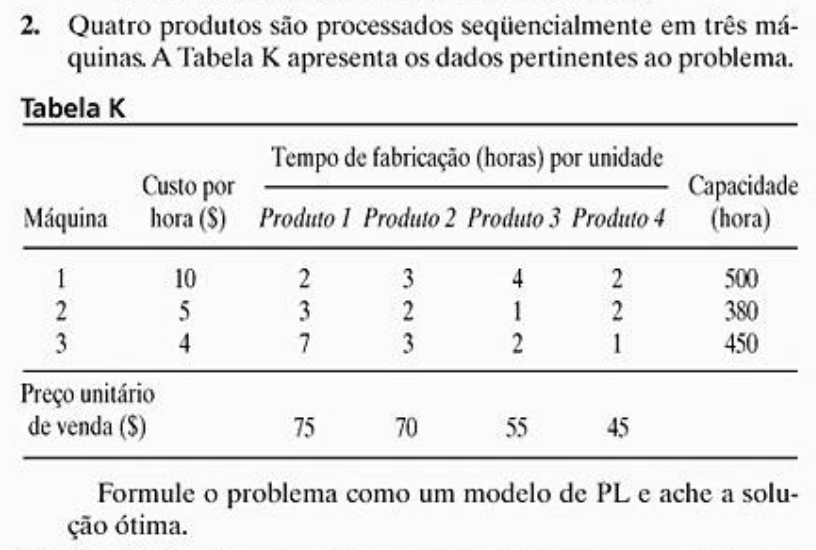

In [6]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Otima_4Produtos_3Maquinas')

In [8]:
# --- Parâmetros extraídos do enunciado e da Tabela K ---

# Identificadores
produtos = [1, 2, 3, 4]
maquinas = [1, 2, 3]

# Dados financeiros
preco_venda = {1: 75, 2: 70, 3: 55, 4: 45}
custo_hora_maquina = {1: 10, 2: 5, 3: 4}

# Dados de produção e capacidade
capacidade_maquina_h = {1: 500, 2: 380, 3: 450}
# Estrutura: tempo_fabricacao[produto][maquina]
tempo_fabricacao_h = {
    1: {1: 2, 2: 3, 3: 7},
    2: {1: 3, 2: 2, 3: 3},
    3: {1: 4, 2: 1, 3: 2},
    4: {1: 2, 2: 2, 3: 1}
}

# Pré-cálculo do lucro líquido por unidade para simplificar a função objetivo
# Custo de produção = Soma (tempo na máquina * custo da máquina)
custo_producao_unitario = {
    p: sum(tempo_fabricacao_h[p][m] * custo_hora_maquina[m] for m in maquinas)
    for p in produtos
}
# Lucro líquido = Preço de Venda - Custo de Produção
lucro_unitario = {p: preco_venda[p] - custo_producao_unitario[p] for p in produtos}
# Lucro P1 = 75 - (2*10 + 3*5 + 7*4) = 75 - 63 = 12
# Lucro P2 = 70 - (3*10 + 2*5 + 3*4) = 70 - 52 = 18
# Lucro P3 = 55 - (4*10 + 1*5 + 2*4) = 55 - 53 = 2
# Lucro P4 = 45 - (2*10 + 2*5 + 1*4) = 45 - 34 = 11

In [9]:
# 1. Variáveis de Decisão
# Número de unidades a serem produzidas de cada produto
num_unidades = model.continuous_var_dict(produtos, name='Prod')
# O problema não especifica que as unidades devem ser inteiras.

# 2. Função Objetivo
# Maximizar o lucro total
expressao_lucro = (lucro_unitario[p] * num_unidades[p] for p in produtos)
lucro_total = model.sum(expressao_lucro)
model.maximize(lucro_total)


# 3. Restrições

# Restrições de capacidade de cada máquina
for m in maquinas:
    expressao_tempo_usado = (tempo_fabricacao_h[p][m] * num_unidades[p] for p in produtos)
    soma_tempo_usado = model.sum(expressao_tempo_usado)
    restr_capacidade_logica = soma_tempo_usado <= capacidade_maquina_h[m]
    model.add_constraint(restr_capacidade_logica, ctname=f'capacidade_maq_{m}')

In [10]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
print(solucao)
lucro_maximo = lucro_total.solution_value
print(f"\nO lucro total máximo é de ${lucro_maximo:,.2f}.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Tried aggregator 1 time.
No LP presolve or aggregator reductions.
Presolve time = 0.00 sec. (0.00 ticks)

Iteration log . . .
Iteration:     1   Dual infeasibility =             0.000000
Iteration:     2   Dual objective     =          3000.000000

------ SOLUÇÃO ÓTIMA ------

solution for: Producao_Otima_4Produtos_3Maquinas
objective: 2950
status: OPTIMAL_SOLUTION(2)
Prod_2=133.333
Prod_4=50.000


O lucro total máximo é de $2,950.00.
